In [1]:
%matplotlib inline

import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py
import csv


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors

#sys.path.insert(0, "../")
from info3d import *
from nn_matchers import *

from query_sets import *

In [2]:
# Global parameters

radius_range = np.arange(0.5,1.6,0.5)

with open('point_collection/new_contiguous_point_collection.pickle','rb') as f: 
    new_contiguous_point_collection = pickle.load(f)

point_collection_indices = np.arange(len(new_contiguous_point_collection))
point_collection_indices

array([0, 1, 2, 3, 4, 5, 6])

# Step 0.3: Create submaps for pointnetvlad using same samples

In [3]:
spatial_span = 2.0

interval = 0.5

num_points = 4096

cutoff = 0.5

In [35]:

with open('point_collection/2_filled_quaternion_vertical_correction_arcore_point_cloud_collection_complete.pickle','rb') as f: 
    arcore_point_cloud_collection = pickle.load(f)
    
arcore_spaces = [[],[],[],[],[],[],[]]
    
for [obj_num, name, timestamp], t_pointCloud, triangles in arcore_point_cloud_collection:
    
    unique_normals = np.unique(np.around(t_pointCloud[:,3:],decimals = 2),axis = 0)
    
    #print(obj_num, name, timestamp, len(unique_normals))
    try:
        arcore_spaces[int(obj_num)].append([
            [obj_num, name, timestamp],
            t_pointCloud, 
            triangles,
            len(unique_normals)
        ])
    except:
        continue
        

chosen_arcore_spaces = [[],[]]

for space in arcore_spaces:
    
    chosen_arcore_spaces[0].append(space[0])
    chosen_arcore_spaces[1].append(space[4])
    
len(arcore_spaces),len(chosen_arcore_spaces[0]),len(chosen_arcore_spaces[1])


(7, 7, 7)

# Step 0.3.1: Generate the reference dataset for arcore

In [39]:
baseline_path = 'pointnetvlad_arcore_submaps_trash/'

if not os.path.exists(baseline_path): os.mkdir(baseline_path)
    
for i in range(len(chosen_arcore_spaces)):
    
    raw_path = os.path.join(baseline_path,"ref_dataset_"+str(i))
    raw_pc_path = os.path.join(raw_path,"pointcloud_4m_0.25")

    if not os.path.exists(raw_path): os.mkdir(raw_path)
    if not os.path.exists(raw_pc_path): os.mkdir(raw_pc_path)

    t0 = time.time()

    csvfile = open(raw_path+"/pointcloud_centroids_4m_0.25.csv",'w',newline = '')

    csv_writer = csv.writer(csvfile, delimiter = ',')
    csv_writer.writerow(['timestamp', 'northing', 'easting','alting','obj'])

    for obj_, [[obj_num, obj_name, timestamp] , pointCloud, triangles, num_normals] in enumerate(chosen_arcore_spaces[i]):

        if obj_num == 0: #object_name == "Reception-Data61-L5.obj":
            new_X = pointCloud[:,0] - np.mean(pointCloud[:,0]) + 50
            new_Z = pointCloud[:,2] - np.mean(pointCloud[:,2]) + 0
        elif obj_num == 1: #object_name == "Driveway.obj":
            new_X = pointCloud[:,0] - np.mean(pointCloud[:,0]) - 25
            new_Z = pointCloud[:,2] - np.mean(pointCloud[:,2]) - 50
        elif obj_num == 2: #object_name == "Apartment.obj":
            new_X = pointCloud[:,0] - np.mean(pointCloud[:,0]) + 25
            new_Z = pointCloud[:,2] - np.mean(pointCloud[:,2]) - 50
        elif obj_num == 3: #object_name == "Workstations-Data61-L4.obj":
            new_X = pointCloud[:,0] - np.mean(pointCloud[:,0]) - 50
            new_Z = pointCloud[:,2] - np.mean(pointCloud[:,2]) + 0
        elif obj_num == 4: #object_name == "Kitchen-Data61-L4.obj":
            new_X = pointCloud[:,0] - np.mean(pointCloud[:,0]) + 0
            new_Z = pointCloud[:,2] - np.mean(pointCloud[:,2]) + 0
        elif obj_num == 5: #object_name == "HallWayToKitchen-Data61-L4.obj":
            new_X = pointCloud[:,0] - np.mean(pointCloud[:,0]) - 25
            new_Z = pointCloud[:,2] - np.mean(pointCloud[:,2]) + 50
        elif obj_num == 6: #object_name == "StairWell-Data61-L4.obj":
            new_X = pointCloud[:,0] - np.mean(pointCloud[:,0]) + 25
            new_Z = pointCloud[:,2] - np.mean(pointCloud[:,2]) + 50
        else:
            print("Error name at",obj_, obj_num, obj_name)
            continue

        new_Y = pointCloud[:,1]

        new_object_pointcloud = np.stack((new_X,new_Z,new_Y)).T

        nbrs = NearestNeighbors(n_neighbors=min(20000,len(new_object_pointcloud)), algorithm='kd_tree').fit(new_object_pointcloud)

        round_new_pointcloud = 0.25*100*np.around((0.01/0.25)*new_object_pointcloud,decimals=2)
        unq_round_pointcloud = np.unique(round_new_pointcloud[:,:3],axis = 0)

        raw_centroids = unq_round_pointcloud#+np.random.normal(0,0.25,unq_round_pointcloud.shape)

        for northing, easting, alting in raw_centroids:

            # Getting the points around our centroid defined by [northing, easting]
            distances, indices = nbrs.kneighbors([[northing, easting, alting]])

            #if max(distances[0]) < 0.5*spatial_span: continue

            submap_pointcloud = new_object_pointcloud[indices[0,np.where(distances[0,:]<=spatial_span)[0]]]

            if len(submap_pointcloud) == 0:
                continue

            # Centering and rescaling
            submap_pointcloud = (submap_pointcloud - [northing, easting, alting])/spatial_span

            if len(submap_pointcloud) > num_points:
                submap_pointcloud = submap_pointcloud[np.random.choice(len(submap_pointcloud),num_points)]
            elif len(submap_pointcloud) < num_points and len(submap_pointcloud) >= cutoff*num_points :
                #print(i,submap_pointcloud.shape)
                additional_pointcloud = submap_pointcloud[np.random.choice(len(submap_pointcloud),num_points-len(submap_pointcloud))]
                additional_pointcloud = additional_pointcloud + np.random.normal(0,0.05,additional_pointcloud.shape)
                submap_pointcloud = np.concatenate((submap_pointcloud,additional_pointcloud),axis = 0)
            elif len(submap_pointcloud) < cutoff*num_points :
                #continue
                #print(i,submap_pointcloud.shape)
                additional_pointcloud = submap_pointcloud[np.random.choice(len(submap_pointcloud),num_points-len(submap_pointcloud), True)]
                additional_pointcloud = additional_pointcloud + np.random.normal(0,0.05,additional_pointcloud.shape)
                submap_pointcloud = np.concatenate((submap_pointcloud,additional_pointcloud),axis = 0)

            timestamp = int(10**16*(time.time()))

            csv_writer.writerow([timestamp,northing,easting,alting,obj_])

            with open(raw_pc_path+'/{}.pickle'.format(timestamp),'wb') as f:
                pickle.dump(submap_pointcloud.T,f)

        print(i,"Done with submap generation for object ({}) {} in {:.3f} seconds".format(obj_,obj_name,time.time()-t0))

    csvfile.close()


0 Done with submap generation for object (0) reception in 5.687 seconds
0 Done with submap generation for object (1) driveway in 8.982 seconds
0 Done with submap generation for object (2) apartment in 9.716 seconds
0 Done with submap generation for object (3) workstation in 10.189 seconds
0 Done with submap generation for object (4) kitchen in 16.692 seconds
0 Done with submap generation for object (5) hallway in 18.060 seconds
0 Done with submap generation for object (6) stairwell in 29.315 seconds
1 Done with submap generation for object (0) reception in 4.099 seconds
1 Done with submap generation for object (1) driveway in 10.844 seconds
1 Done with submap generation for object (2) apartment in 12.080 seconds
1 Done with submap generation for object (3) workstation in 12.525 seconds
1 Done with submap generation for object (4) kitchen in 22.851 seconds
1 Done with submap generation for object (5) hallway in 24.233 seconds
1 Done with submap generation for object (6) stairwell in 35.

Done generating 1000 samples in 0.063 seconds.


(array([144., 121., 159., 154., 155., 138., 129.]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <a list of 7 Patch objects>)

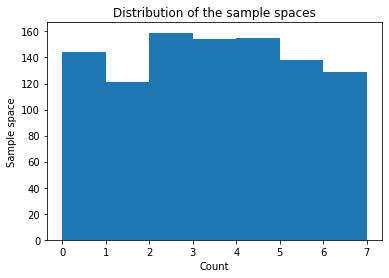

In [6]:
samples = 1000

sample_arcore_points = []

samples_indeces = []

t0 = time.time()

for i in np.arange(samples):

    random_space = np.random.randint(len(arcore_spaces))
    random_sample = np.random.randint(len(arcore_spaces[random_space]))

    object_name = arcore_spaces[random_space][random_sample][0][1]
    pointCloud = arcore_spaces[random_space][random_sample][1]
    triangles = arcore_spaces[random_space][random_sample][2]
    
    triangle_index = np.random.choice(np.arange(len(triangles)))
    vertex_index = triangles[triangle_index,1]
    original_vertex = pointCloud[vertex_index]

    sample_arcore_points.append([
        random_space,
        random_sample, 
        object_name, 
        original_vertex
    ])
    
    samples_indeces.append(random_space)
    
print("Done generating",len(sample_arcore_points),"samples in {:.3f} seconds.".format(time.time()-t0))

with open('sample_arcore_points.pickle','wb') as f:
    pickle.dump(sample_arcore_points,f)
    
plt.title("Distribution of the sample spaces")
plt.xlabel("Count")
plt.ylabel("Sample space")
plt.hist(samples_indeces,bins = np.arange(0,8))

# Step 0.3.3: Generate the test submaps:
 - using Raw spaces for validation
 - using Ransac spaces for evaluation
 - using Ransac spaces for the successive case

In [31]:
# One-time releases Raw partial spaces

baseline_path = 'pointnetvlad_arcore_submaps/'

if not os.path.exists(baseline_path): os.mkdir(baseline_path)

for radius in np.arange(3.0,5.1,0.25):
    
    per_radius_partial_length = []
    
    t1 = time.time()
            
    partial_path = os.path.join(baseline_path,"partial_radius_"+str(radius))
    pointcloud_partial_path = os.path.join(partial_path,"pointcloud_4m")
    #pointcloud_partial_bin_path = os.path.join(partial_path,"pointcloud_4m_npy")

    if not os.path.exists(partial_path): os.mkdir(partial_path)
    if not os.path.exists(pointcloud_partial_path): os.mkdir(pointcloud_partial_path)
    #if not os.path.exists(pointcloud_partial_bin_path): os.mkdir(pointcloud_partial_bin_path)

    print(" ",pointcloud_partial_path)
    #"""
    csvfile = open(partial_path+"/pointcloud_centroids_4m.csv",'w',newline = '')

    csv_writer = csv.writer(csvfile, delimiter = ',')
    csv_writer.writerow(['timestamp', 'northing', 'easting', 'alting','obj'])
    #"""
    count = 0
    
    for obj_, obj_sample, object_name, original_vertex in sample_arcore_points:
        
        new_partial_pointcloud = []
        new_vX = []
        new_vZ = []
        
        try:
            object_, ransac_pointCloud, tri_, u_n_ = arcore_spaces[obj_][obj_sample]
            
            ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(ransac_pointCloud)), algorithm='kd_tree').fit(ransac_pointCloud[:,:3])
            
            dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
            pointCloud =  ransac_pointCloud[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
            
        except:
            print("Can't get pointcloud for",obj_, sample, object_name, original_vertex)
            continue
            
        #if len(gen_planes) == 0: continue
        if len(pointCloud) == 0: continue

        if obj_ == 0: #object_name == "Reception-Data61-L5.obj":
            new_X = pointCloud[:,0] + 50
            new_Z = pointCloud[:,2] + 0
            new_vX = original_vertex[0] + 50
            new_vZ = original_vertex[2] + 0
        elif obj_ == 1: #object_name == "Driveway.obj":
            new_X = pointCloud[:,0] - 25
            new_Z = pointCloud[:,2] - 50
            new_vX = original_vertex[0] - 25
            new_vZ = original_vertex[2] - 50
        elif obj_ == 2: #object_name == "Apartment.obj":
            new_X = pointCloud[:,0] + 25
            new_Z = pointCloud[:,2] - 50
            new_vX = original_vertex[0] + 25
            new_vZ = original_vertex[2] - 50
        elif obj_ == 3: #object_name == "Workstations-Data61-L4.obj":
            new_X = pointCloud[:,0] - 50
            new_Z = pointCloud[:,2] + 0
            new_vX = original_vertex[0] - 50
            new_vZ = original_vertex[2] + 0
        elif obj_ == 4: #object_name == "Kitchen-Data61-L4.obj":
            new_X = pointCloud[:,0] + 0
            new_Z = pointCloud[:,2] + 0
            new_vX = original_vertex[0] + 0
            new_vZ = original_vertex[2] + 0
        elif obj_ == 5: #object_name == "HallWayToKitchen-Data61-L4.obj":
            new_X = pointCloud[:,0] - 25
            new_Z = pointCloud[:,2] + 50
            new_vX = original_vertex[0] - 25
            new_vZ = original_vertex[2] + 50
        elif obj_ == 6: #object_name == "StairWell-Data61-L4.obj":
            new_X = pointCloud[:,0] + 25
            new_Z = pointCloud[:,2] + 50
            new_vX = original_vertex[0] + 25
            new_vZ = original_vertex[2] + 50
        else:
            print("Error:",obj_meta)

        new_Y = pointCloud[:,1]

        new_partial_pointcloud = np.stack((new_X,new_Z,new_Y)).T
        
        max_known_span = max(np.amax(new_partial_pointcloud, axis = 0) - np.amin(new_partial_pointcloud, axis = 0))
        
        nbrs = NearestNeighbors(n_neighbors=min(2*num_points,len(new_partial_pointcloud)), algorithm='kd_tree').fit(new_partial_pointcloud)

        # Get submap "centroids" by quantizing by 0.25m, i.e. round then unique
        if max_known_span > 3*spatial_span:
            round_new_partial_pointcloud = 100*np.around(0.01*new_partial_pointcloud,decimals=2)
            unq_round_partial_pointcloud = np.unique(round_new_partial_pointcloud[:,:3],axis = 0)
        #    
            raw_partial_centroids = unq_round_partial_pointcloud
            c_nbrs = NearestNeighbors(n_neighbors = min(25,len(raw_partial_centroids)),  algorithm='kd_tree').fit(raw_partial_centroids)
            c_dist, c_ind = c_nbrs.kneighbors(raw_partial_centroids)

            ia1, ia2 = np.where(c_dist < 1.73)
            

            dist_bins = np.bincount(ia1)
            max_dist = max(np.bincount(ia1))
            raw_partial_centroids = raw_partial_centroids[[i for i, j in enumerate(dist_bins) if j == max_dist]]
            
            raw_partial_centroids = raw_partial_centroids+np.random.normal(0,interval,raw_partial_centroids.shape)
            
        else:
            # Correcting this, because the attacker is supposed to not know the true centroid
            # and has to estimate it instead.
            #raw_partial_centroids = [[new_vX, new_vZ, original_vertex[1]]]        

            raw_partial_centroids = [np.mean(new_partial_pointcloud, axis = 0)]
            
        for northing, easting, alting in raw_partial_centroids:
            
            # Getting the points around our centroid defined by [northing, easting]
            distances, indices = nbrs.kneighbors([[northing, easting, alting]])
            
            #if max(distances[0]) < 0.5*spatial_span: continue
                
            submap_pointcloud = new_partial_pointcloud[indices[0,np.where(distances[0,:]<=spatial_span)[0]]]

            if len(submap_pointcloud) == 0:
                continue
            
            # Centering and rescaling
            submap_pointcloud = (submap_pointcloud - [northing, easting, alting])/spatial_span

            if len(submap_pointcloud) > num_points:
                submap_pointcloud = submap_pointcloud[np.random.choice(len(submap_pointcloud),num_points)]
            elif len(submap_pointcloud) < num_points and len(submap_pointcloud) >= cutoff*num_points :
                #print(i,submap_pointcloud.shape)
                additional_pointcloud = submap_pointcloud[np.random.choice(len(submap_pointcloud),num_points-len(submap_pointcloud))]
                additional_pointcloud = additional_pointcloud + np.random.normal(0,0.05,additional_pointcloud.shape)
                submap_pointcloud = np.concatenate((submap_pointcloud,additional_pointcloud),axis = 0)
            elif len(submap_pointcloud) < cutoff*num_points :
                #continue
                #print(i,submap_pointcloud.shape)
                additional_pointcloud = submap_pointcloud[np.random.choice(len(submap_pointcloud),num_points-len(submap_pointcloud), True)]
                additional_pointcloud = additional_pointcloud + np.random.normal(0,0.05,additional_pointcloud.shape)
                submap_pointcloud = np.concatenate((submap_pointcloud,additional_pointcloud),axis = 0)

            timestamp = int(10**16*(time.time()))
            
            csv_writer.writerow([timestamp,northing,easting,alting,obj_])
            
            with open(pointcloud_partial_path+'/{}.pickle'.format(timestamp),'wb') as f:
                pickle.dump(submap_pointcloud.T,f)

            count += 1


    print("   Done with submap generation for radius {} ( {} samples) in {:.3f} seconds".format(radius,count,time.time()-t1))
    csvfile.close()
       

  pointnetvlad_arcore_submaps/partial_radius_3.0/pointcloud_4m
   Done with submap generation for radius 3.0 ( 1000 samples) in 16.151 seconds
  pointnetvlad_arcore_submaps/partial_radius_3.25/pointcloud_4m
   Done with submap generation for radius 3.25 ( 6270 samples) in 34.263 seconds
  pointnetvlad_arcore_submaps/partial_radius_3.5/pointcloud_4m
   Done with submap generation for radius 3.5 ( 7501 samples) in 41.841 seconds
  pointnetvlad_arcore_submaps/partial_radius_3.75/pointcloud_4m
   Done with submap generation for radius 3.75 ( 8648 samples) in 45.844 seconds
  pointnetvlad_arcore_submaps/partial_radius_4.0/pointcloud_4m
   Done with submap generation for radius 4.0 ( 9607 samples) in 49.289 seconds
  pointnetvlad_arcore_submaps/partial_radius_4.25/pointcloud_4m
   Done with submap generation for radius 4.25 ( 10671 samples) in 51.836 seconds
  pointnetvlad_arcore_submaps/partial_radius_4.5/pointcloud_4m
   Done with submap generation for radius 4.5 ( 11581 samples) in 61.691

# Step 0.3.4: Building database and query files for evaluation with pointnetVLAD 
 - the combined Raw and RANSAC referece database 
 - for validation with one-time released Raw spaces
 - for testing with one-time released RANSAC spaces
 - for testing with successive RANSAC spaces

In [28]:
base_path= "pointnetvlad_arcore_submaps/"#"../partial_dataset/"

construct_query_and_database_sets(
    base_path, 
    ['ref_dataset_0','ref_dataset_1'], 
    "/pointcloud_4m_0.25/",
    "pointcloud_centroids_4m_0.25.csv",
    True
)#, all_folders[index])


ref_dataset_0
ref_dataset_1
Done getting database trees.
Database (Tree) sets: 2
Done  pointnetvlad_arcore_submaps/3d_evaluation_database.pickle


In [32]:
# For the Ransac queries.

for radius in np.arange(3.0,5.1,0.5):
    
    partial_path = 'partial_radius_'+str(radius)
    
    print(partial_path)
    construct_query_sets(
        base_path,
        partial_path, 
        "/pointcloud_4m/", 
        "pointcloud_centroids_4m.csv"
    )


partial_radius_3.0
 Test (Tree) sets: 1
Done  pointnetvlad_arcore_submaps/3d_partial_radius_3.0_evaluation_query.pickle
partial_radius_3.5
 Test (Tree) sets: 1
Done  pointnetvlad_arcore_submaps/3d_partial_radius_3.5_evaluation_query.pickle
partial_radius_4.0
 Test (Tree) sets: 1
Done  pointnetvlad_arcore_submaps/3d_partial_radius_4.0_evaluation_query.pickle
partial_radius_4.5
 Test (Tree) sets: 1
Done  pointnetvlad_arcore_submaps/3d_partial_radius_4.5_evaluation_query.pickle
partial_radius_5.0
 Test (Tree) sets: 1
Done  pointnetvlad_arcore_submaps/3d_partial_radius_5.0_evaluation_query.pickle
